In [55]:
import numpy as np
import pandas as pd
from dca_oop import ARPS
import matplotlib.pyplot as plt

In [56]:
#inputs:
well_names_col="NPD_WELL_BORE_NAME"
well_name="15/9-F-14"
prod_col_name="BORE_OIL_VOL"
date_col_name="DATEPRD"

In [57]:
# function to load the data
def load_data(filepath , well_names_col ,well_name , prod_col_name , date_col_name):

     df= pd.read_excel(filepath,parse_dates=True)

    # filtring to the specific well
     df = df [ df[well_names_col] == well_name][[date_col_name,prod_col_name]]
   # rename columns
     df.columns = ["date","production"]


    # return the dataframe with only the two columns [ data , production ], and they must be with the same name
     return df

In [58]:
df = load_data("Volve production data.xlsx",well_names_col ,well_name , prod_col_name , date_col_name)
df.head()

,date,production
4967,2008-02-12,0.0
4968,2008-02-13,0.0
4969,2008-02-14,0.0
4970,2008-02-15,0.0
4971,2008-02-16,0.0


<Axes: xlabel='date'>

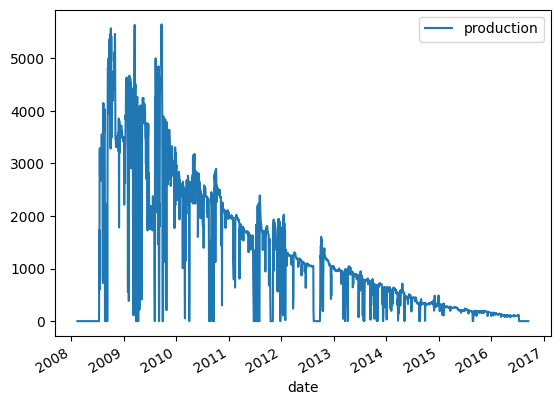

In [59]:
df.plot(x="date",y="production")

In [60]:
#inputs
window_size=100
stds=5
# ================== FITTING INTERVAL (USER INPUTS) ==================
fit_start = "2009-01-01"   # inclusive
fit_end   = "2014-12-31"   # inclusive

In [61]:
arps_all = ARPS(dataframe=df, production_col="production", date_column="date")
df_smoothed_all = arps_all.smooth(window_size=window_size, stds=stds, trim=True).copy()
df_smoothed_all["date"] = pd.to_datetime(df_smoothed_all["date"])

In [62]:
min_points = 5

# --- build fit subset from the full smoothed data (dates + raw prod) ---
mask = (df_smoothed_all["date"] >= pd.to_datetime(fit_start)) & \
       (df_smoothed_all["date"] <= pd.to_datetime(fit_end))
df_fit = df_smoothed_all.loc[mask, ["date", "production"]].copy()
df_fit

,date,production
13,2009-01-01,3478.64
14,2009-01-02,3363.80
15,2009-01-03,2216.90
16,2009-01-04,3347.77
17,2009-01-05,3495.80
...,...,...
2112,2014-12-27,314.02
2113,2014-12-28,319.75
2114,2014-12-29,292.71
2115,2014-12-30,376.06


In [63]:
# safety check
if len(df_fit) < min_points:
    raise ValueError(f"Not enough data points in the fitting interval "
                     f"({len(df_fit)} found, need at least {min_points}).")

# --- re-fit and re-smooth ONLY the interval (so interval smoothing matches class logic) ---
arps_fit = ARPS(dataframe=df_fit, production_col="production", date_column="date")
df_fit_smoothed = arps_fit.smooth(window_size=window_size, stds=stds, trim=True).copy()
df_fit_smoothed["date"] = pd.to_datetime(df_fit_smoothed["date"])


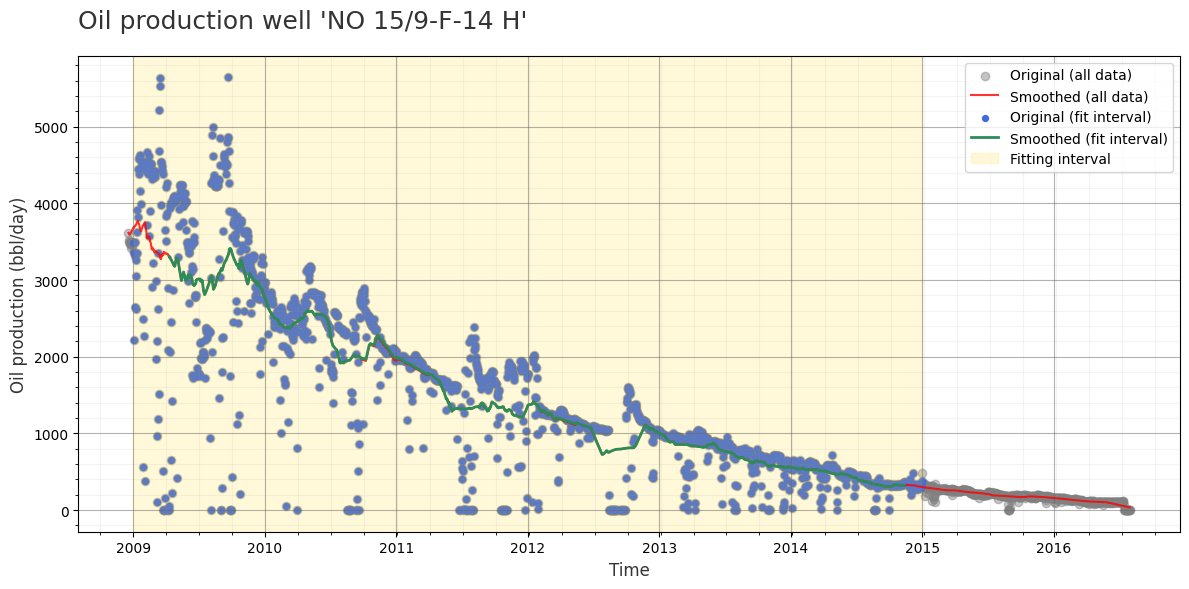

In [64]:
# --- plot: full vs fit interval (one figure) ---
plt.figure(figsize=(12, 6))

# full data
plt.scatter(df_smoothed_all["date"], df_smoothed_all["production"],
            label="Original (all data)", alpha=0.45, color="gray")
plt.plot(df_smoothed_all["date"], df_smoothed_all["production_rol_Av"],
         label="Smoothed (all data)", color="red", alpha=0.8)

# fit interval data
plt.scatter(df_fit["date"], df_fit["production"],
            label="Original (fit interval)", color="royalblue", s=18)
plt.plot(df_fit_smoothed["date"], df_fit_smoothed["production_rol_Av"],
         label="Smoothed (fit interval)", color="seagreen", linewidth=2)

# shade the fitting window
plt.axvspan(pd.to_datetime(fit_start), pd.to_datetime(fit_end),
            color="gold", alpha=0.15, label="Fitting interval")

# formatting
plt.title("Oil production well 'NO 15/9-F-14 H'", fontsize=18, color="#333", loc="left", pad=20)
plt.xlabel("Time", fontsize=12, color="#333")
plt.ylabel("Oil production (bbl/day)", fontsize=12, color="#333")
plt.grid(which="major", color="#6666", linestyle="-", alpha=.5)
plt.grid(which="minor", color="#9999", linestyle="-", alpha=.1)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.show()


In [65]:
arps_fit.prepocess_date_col(frequency="Daily")

In [66]:
parameters, flow_rates, best_model = arps_fit.fit_all_models()


In [67]:
parameters


,Model,Qi,Qi_std,Di,Di_std,b,b_std,Normalized RMSE
0,ex,3517.294553,10.220990,0.001024,0.000005,0.000000,0.000000,0.043869
1,hp,3517.291031,13.507561,0.001024,0.000014,0.000001,0.016813,0.043869
2,hr,3886.057567,28.148825,0.002097,0.000033,1.000000,0.000000,0.080527


In [68]:
flow_rates

,Original_Smoothed,Exponential,Hyperbolic,Harmonic,Date
Time,,,,,
0,3307.1587,3517.294553,3517.291031,3886.057567,2009-04-11
1,3296.4910,3513.694180,3513.690667,3877.926021,2009-04-12
2,3301.5696,3510.097492,3510.093989,3869.828434,2009-04-13
3,3288.3254,3506.504485,3506.500992,3861.764594,2009-04-14
4,3277.6741,3502.915157,3502.911674,3853.734290,2009-04-15
...,...,...,...,...,...
2037,323.1105,436.708199,436.710337,737.204172,2014-11-08
2038,322.9956,436.261176,436.263313,736.911037,2014-11-09
2039,322.5219,435.814610,435.816747,736.618136,2014-11-10


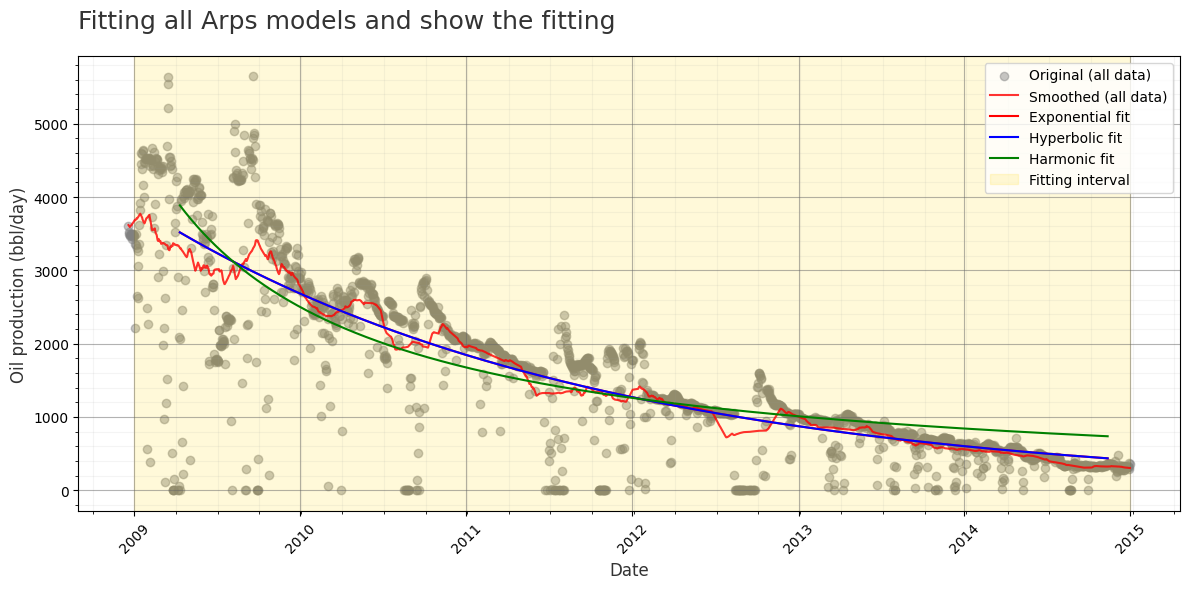

In [69]:
plt.figure(figsize=(12, 6))

# convert to datetime for slicing
fit_end_dt = pd.to_datetime(fit_end)

# --- clip datasets up to fit_end ---
df_all_clip = df_smoothed_all[df_smoothed_all["date"] <= fit_end_dt]
flow_rates_clip = flow_rates[flow_rates["Date"] <= fit_end_dt]

# full data (up to fit_end)
plt.scatter(df_all_clip["date"], df_all_clip["production"],
            label="Original (all data)", alpha=0.45, color="gray")
plt.plot(df_all_clip["date"], df_all_clip["production_rol_Av"],
         label="Smoothed (all data)", color="red", alpha=0.8)

# fitted models (up to fit_end)
plt.plot(flow_rates_clip["Date"], flow_rates_clip["Exponential"],
         label="Exponential fit", color="red")
plt.plot(flow_rates_clip["Date"], flow_rates_clip["Hyperbolic"],
         label="Hyperbolic fit", color="blue")
plt.plot(flow_rates_clip["Date"], flow_rates_clip["Harmonic"],
         label="Harmonic fit", color="green")

# shade the fitting window
plt.axvspan(pd.to_datetime(fit_start), pd.to_datetime(fit_end),
            color="gold", alpha=0.15, label="Fitting interval")

# --- formatting ---
plt.title("Fitting all Arps models and show the fitting",
          fontsize=18, color="#333", loc="left", pad=20)
plt.xlabel("Date", fontsize=12, color="#333")
plt.ylabel("Oil production (bbl/day)", fontsize=12, color="#333")

plt.grid(which="major", color="#6666", linestyle="-", alpha=.5)
plt.grid(which="minor", color="#9999", linestyle="-", alpha=.1)
plt.minorticks_on()
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [70]:
def arps_rate(t, Qi, Di, b):
    t = np.asarray(t, dtype=float)
    if np.isclose(b, 0.0):          # Exponential
        return Qi * np.exp(-Di * t)
    elif np.isclose(b, 1.0):        # Harmonic
        return Qi / (1.0 + Di * t)
    else:                           # Hyperbolic (general b)
        return Qi / np.power(1.0 + b * Di * t, 1.0 / b)

def forecast_all_models(parameters, flow_rates, start_date, end_date):
    # time origin = first date of the dataset used to fit the models
    f = flow_rates.copy()
    f["Date"] = pd.to_datetime(f["Date"])
    t0 = f["Date"].min()

    # prediction date grid
    start_date = pd.to_datetime(start_date)
    end_date   = pd.to_datetime(end_date)
    dates = pd.date_range(start=start_date, end=end_date, freq="D")

    # absolute time since fit origin (days); clamp negative to 0 to avoid pre-fit extrapolation
    t_abs = (dates - t0).days
    t_abs = np.clip(t_abs, 0, None)

    # build output
    out = pd.DataFrame({"Date": dates})
    for _, row in parameters.iterrows():
        model = row["Model"]  # 'ex', 'hp', or 'hr'
        Qi, Di, b = float(row["Qi"]), float(row["Di"]), float(row["b"])
        out[model] = arps_rate(t_abs, Qi, Di, b)

    return out


In [71]:
start_date = pd.to_datetime(fit_end)   # your fit_end as the new start
end_date = ""                          # user input, leave empty for default

# if user did not specify end_date → set to +2 years
if end_date == "" or end_date is None:
    end_date = start_date + pd.DateOffset(years=2)
else:
    end_date = pd.to_datetime(end_date)

print("Start:", start_date.date())
print("End:", end_date.date())

Start: 2014-12-31
End: 2016-12-31


In [72]:
forecast_df = forecast_all_models(parameters, flow_rates, start_date, end_date)
forecast_df

,Date,ex,hp,hr
0,2014-12-31,413.635678,413.637791,721.982762
1,2015-01-01,413.212272,413.214384,721.701605
2,2015-01-02,412.789300,412.791411,721.420667
3,2015-01-03,412.366761,412.368871,721.139948
4,2015-01-04,411.944654,411.946764,720.859447
...,...,...,...,...
727,2016-12-27,196.454844,196.456475,562.633166
728,2016-12-28,196.253749,196.255380,562.462407
729,2016-12-29,196.052859,196.054490,562.291752
730,2016-12-30,195.852176,195.853805,562.121200


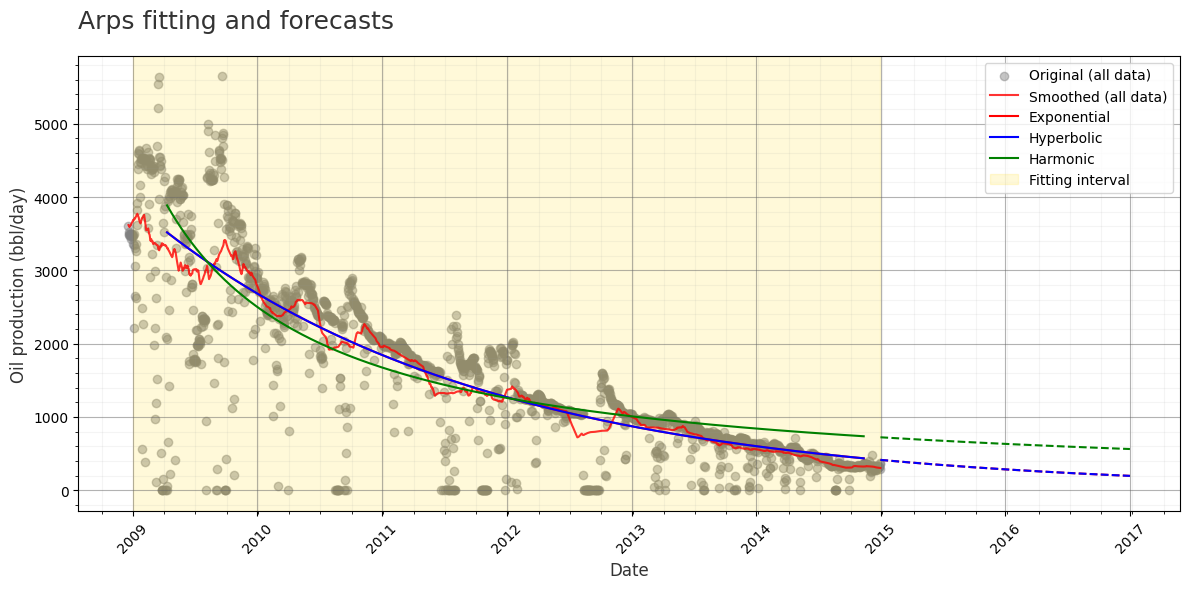

In [73]:
plt.figure(figsize=(12, 6))

# convert to datetime for slicing
fit_end_dt = pd.to_datetime(fit_end)

# --- clip datasets up to fit_end ---
df_all_clip = df_smoothed_all[df_smoothed_all["date"] <= fit_end_dt]
flow_rates_clip = flow_rates[flow_rates["Date"] <= fit_end_dt]

# full data (up to fit_end)
plt.scatter(df_all_clip["date"], df_all_clip["production"],
            label="Original (all data)", alpha=0.45, color="gray")
plt.plot(df_all_clip["date"], df_all_clip["production_rol_Av"],
         label="Smoothed (all data)", color="red", alpha=0.8)

# fitted + forecast models (same colors, one legend entry each)
plt.plot(flow_rates_clip["Date"], flow_rates_clip["Exponential"],
         label="Exponential", color="red")
plt.plot(forecast_df["Date"], forecast_df["ex"],
         color="red", linestyle="--", label="_nolegend_")

plt.plot(flow_rates_clip["Date"], flow_rates_clip["Hyperbolic"],
         label="Hyperbolic", color="blue")
plt.plot(forecast_df["Date"], forecast_df["hp"],
         color="blue", linestyle="--", label="_nolegend_")

plt.plot(flow_rates_clip["Date"], flow_rates_clip["Harmonic"],
         label="Harmonic", color="green")
plt.plot(forecast_df["Date"], forecast_df["hr"],
         color="green", linestyle="--", label="_nolegend_")

# shade the fitting window
plt.axvspan(pd.to_datetime(fit_start), pd.to_datetime(fit_end),
            color="gold", alpha=0.15, label="Fitting interval")

# --- formatting ---
plt.title("Arps fitting and forecasts", fontsize=18, color="#333", loc="left", pad=20)
plt.xlabel("Date", fontsize=12, color="#333")
plt.ylabel("Oil production (bbl/day)", fontsize=12, color="#333")

plt.grid(which="major", color="#6666", linestyle="-", alpha=.5)
plt.grid(which="minor", color="#9999", linestyle="-", alpha=.1)
plt.minorticks_on()
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [74]:
#inputs
n_scenarios=1000
discount_rate=.1
oil_price_mean=70
oil_price_std=10

In [75]:
# ----- Monte Carlo simulation -----
def monte_carlo_simulation(parameters, flow_rates,
                           start_date, end_date,
                           n_scenarios=1000,
                           discount_rate=0.1,
                           price_mean=70, price_std=10):
    """
    Monte Carlo simulation of production + NPV for 3 Arps models.
    """
    # time setup
    flow_rates = flow_rates.copy()
    flow_rates["Date"] = pd.to_datetime(flow_rates["Date"])
    t0 = flow_rates["Date"].min()

    start_date = pd.to_datetime(start_date)
    end_date   = pd.to_datetime(end_date)
    dates = pd.date_range(start=start_date, end=end_date, freq="D")

    t_abs = (dates - t0).days
    n_steps = len(dates)

    # storage
    results = {model: {"TotalProd": [], "NPV": []} for model in parameters["Model"]}

    # Monte Carlo loop
    for _ in range(n_scenarios):
        # simulate oil price trajectory (time-varying)
        price_path = np.random.normal(price_mean, price_std, n_steps)

        for _, row in parameters.iterrows():
            model = row["Model"]

            # sample parameters (constant for this scenario)
            Qi = np.random.normal(row["Qi"], row["Qi_std"])
            Di = np.random.normal(row["Di"], row["Di_std"])
            b  = np.random.normal(row["b"],  row["b_std"])

            # ensure positive rates
            Qi = max(Qi, 1e-6)
            Di = max(Di, 1e-8)

            # production forecast
            q_t = arps_rate(t_abs, Qi, Di, b)

            # total production
            total_prod = np.trapz(q_t, dx=1)   # approximate integral over time

            # revenues
            revenues = q_t * price_path

            # discount factor
            discount_factors = 1 / np.power((1 + discount_rate), t_abs/365.0)

            # npv
            npv = np.sum(revenues * discount_factors)

            # store
            results[model]["TotalProd"].append(total_prod)
            results[model]["NPV"].append(npv)

    # convert results to DataFrame
    out = {}
    for model in results:
        out[f"{model}_TotalProd"] = results[model]["TotalProd"]
        out[f"{model}_NPV"] = results[model]["NPV"]

    return pd.DataFrame(out)




In [76]:
# ---------------- example usage ----------------
# forecast 1000 scenarios from 2010-01-01 to 2015-12-31
mc_results = monte_carlo_simulation(
    parameters=parameters,
    flow_rates=flow_rates,
    start_date=start_date,
    end_date=end_date,
    n_scenarios=n_scenarios,
    discount_rate=discount_rate,
    price_mean=oil_price_mean, price_std=oil_price_std
)

# mc_results now has columns like:
# ['ex_TotalProd','ex_NPV','hp_TotalProd','hp_NPV','hr_TotalProd','hr_NPV']

C:\Users\abshahin\AppData\Local\Temp\ipykernel_47772\3656867602.py:46: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_prod = np.trapz(q_t, dx=1)   # approximate integral over time


In [77]:
mc_results

,ex_TotalProd,ex_NPV,hp_TotalProd,hp_NPV,hr_TotalProd,hr_NPV
0,208511.646714,7.844341e+06,224488.623292,8.440531e+06,462015.673671,1.722436e+07
1,217330.102575,8.113490e+06,208155.006571,7.774331e+06,467749.350794,1.732967e+07
2,209903.737850,7.910964e+06,205360.617204,7.739852e+06,467926.729036,1.748063e+07
3,212383.521515,7.964870e+06,216281.190841,8.110922e+06,476605.039172,1.772941e+07
4,214613.720478,8.042974e+06,207488.734783,7.777570e+06,471643.885948,1.754630e+07
...,...,...,...,...,...,...
995,211863.596783,7.937053e+06,228870.896720,8.569605e+06,475204.162792,1.766589e+07
996,213892.704915,8.043026e+06,213343.873070,8.025119e+06,474178.090027,1.770620e+07
997,212474.821083,7.925572e+06,203109.746232,7.578065e+06,455503.434306,1.686206e+07
998,214266.432219,8.027648e+06,213948.723321,8.015370e+06,462337.885026,1.719911e+07


In [78]:
def summarize_and_plot(mc_results, model, metric="TotalProd"):
    """
    Plot histogram + CDF for a given model and metric (TotalProd or NPV).
    Adds vertical lines for mean, P10, P90.
    """
    # extract the column
    col = f"{model}_{metric}"
    data = mc_results[col].values

    # compute stats
    mean_val = np.mean(data)
    p10 = np.percentile(data, 10)
    p90 = np.percentile(data, 90)

    # histogram
    plt.figure(figsize=(10,5))
    plt.hist(data, bins=30, alpha=0.7, color="skyblue", edgecolor="k")
    plt.axvline(mean_val, color="red", linestyle="--", label=f"Mean: {mean_val:,.0f}")
    plt.axvline(p10, color="green", linestyle="--", label=f"P10: {p10:,.0f}")
    plt.axvline(p90, color="blue", linestyle="--", label=f"P90: {p90:,.0f}")
    plt.title(f"Histogram of {col}", fontsize=14)
    plt.xlabel(metric)
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # cumulative distribution
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)

    plt.figure(figsize=(10,5))
    plt.plot(sorted_data, cdf, color="black")
    plt.axvline(mean_val, color="red", linestyle="--", label=f"Mean: {mean_val:,.0f}")
    plt.axvline(p10, color="green", linestyle="--", label=f"P10: {p10:,.0f}")
    plt.axvline(p90, color="blue", linestyle="--", label=f"P90: {p90:,.0f}")
    plt.title(f"CDF of {col}", fontsize=14)
    plt.xlabel(metric)
    plt.ylabel("Cumulative Probability")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return {"mean": mean_val, "P10": p10, "P90": p90}




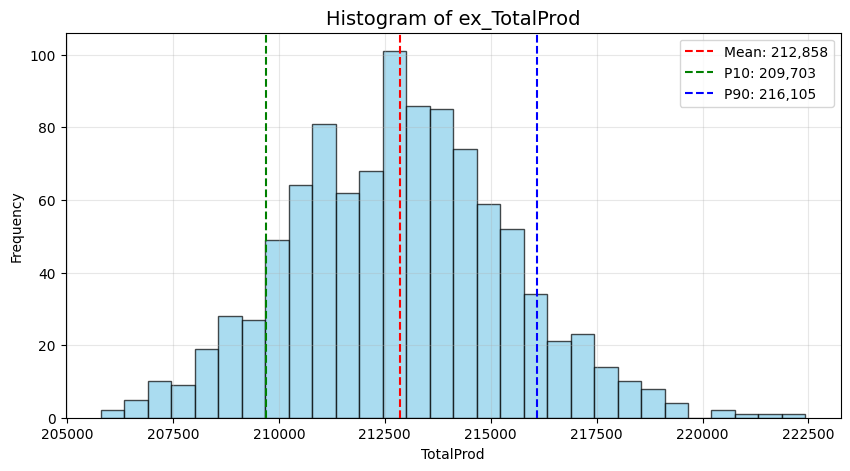

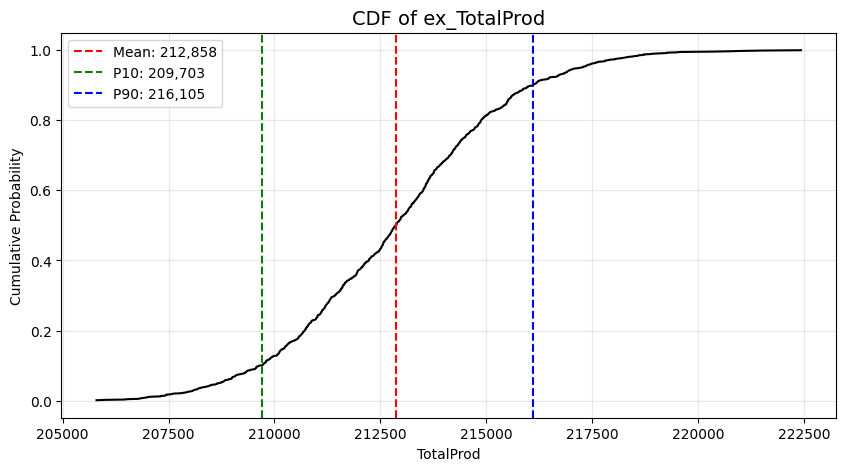

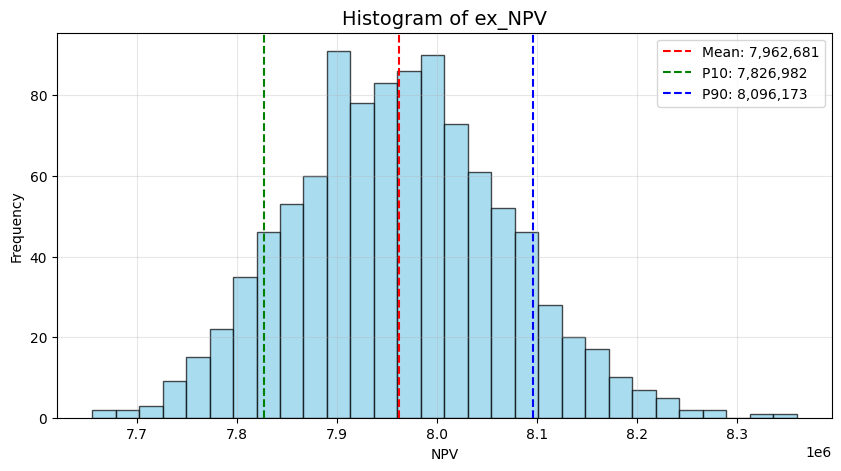

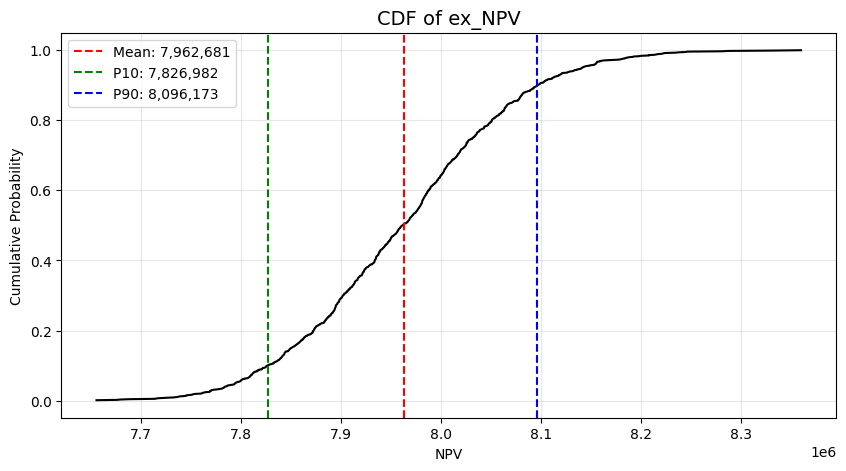

In [79]:
# ---------------- Example usage ----------------
# For exponential model - Total Production
summary_ex_prod = summarize_and_plot(mc_results, "ex", "TotalProd")

# For exponential model - NPV
summary_ex_npv = summarize_and_plot(mc_results, "ex", "NPV")

# Repeat with "hp" or "hr" for other models

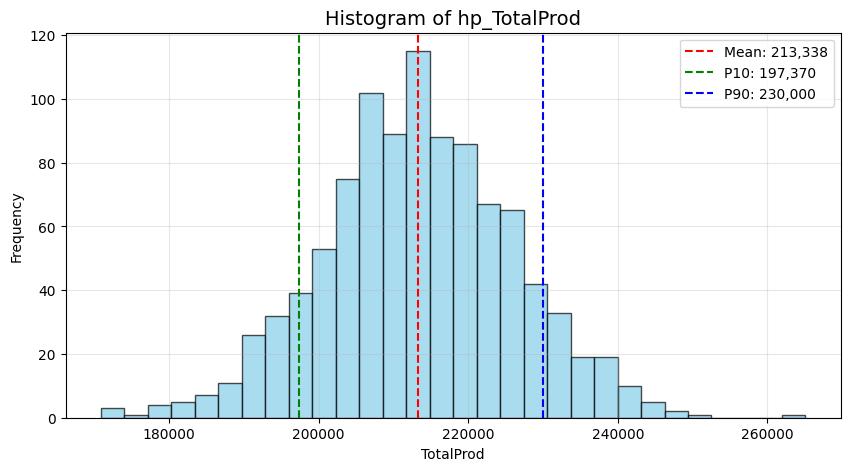

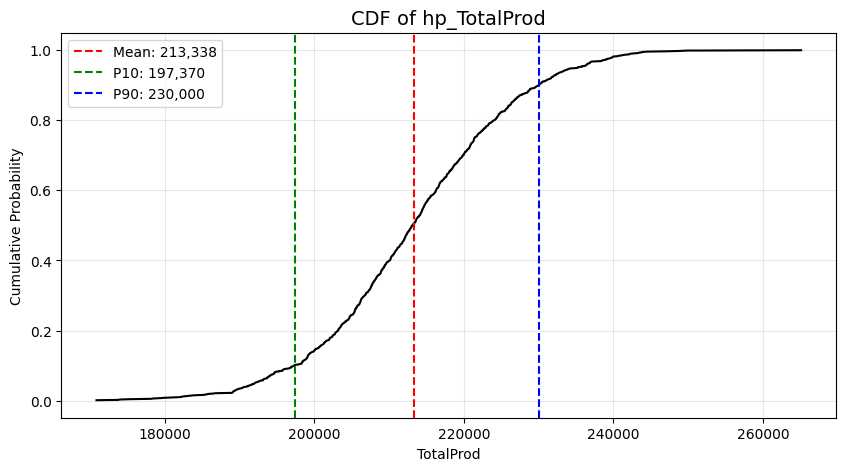

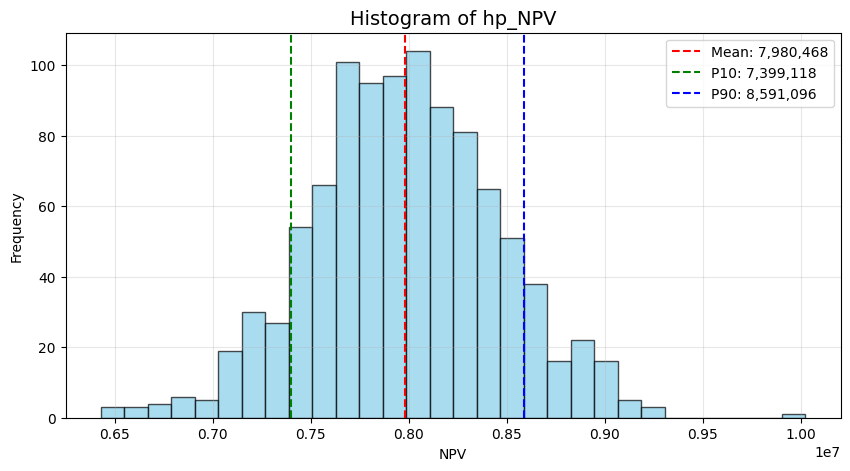

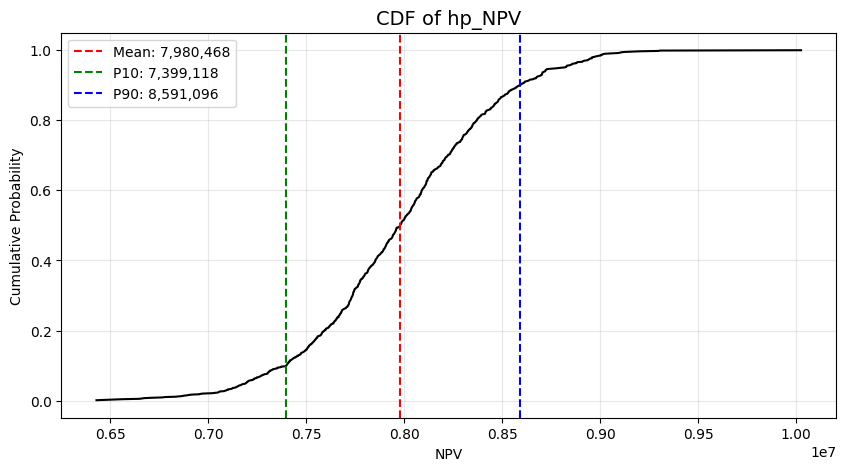

In [80]:
# ---------------- Example usage ----------------
# For exponential model - Total Production
summary_ex_prod = summarize_and_plot(mc_results, "hp", "TotalProd")

# For exponential model - NPV
summary_ex_npv = summarize_and_plot(mc_results, "hp", "NPV")

# Repeat with "hp" or "hr" for other models

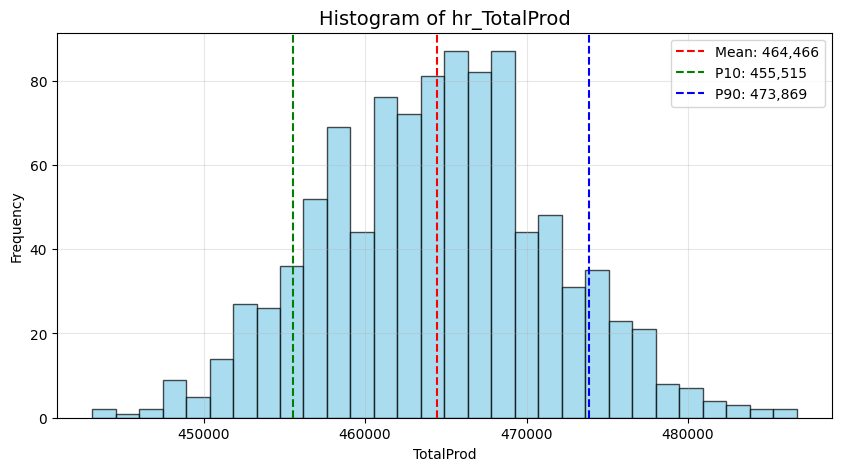

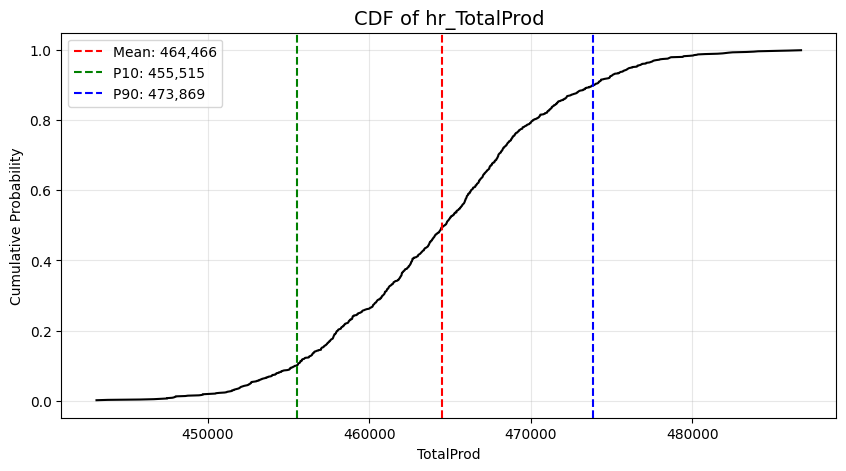

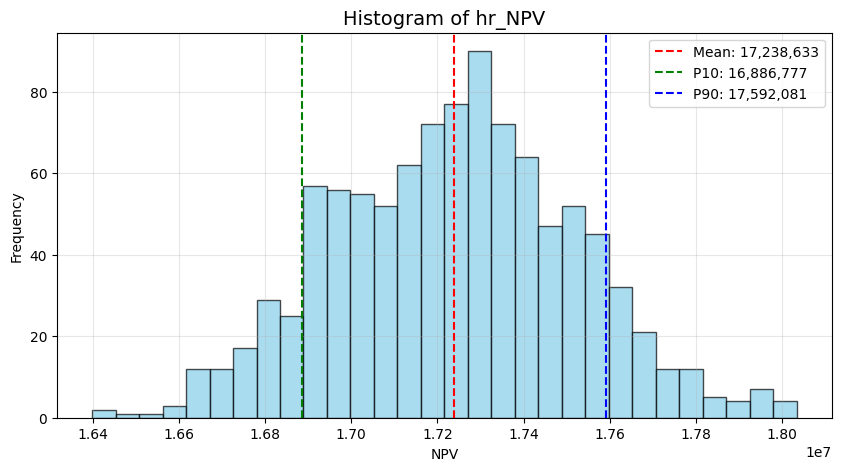

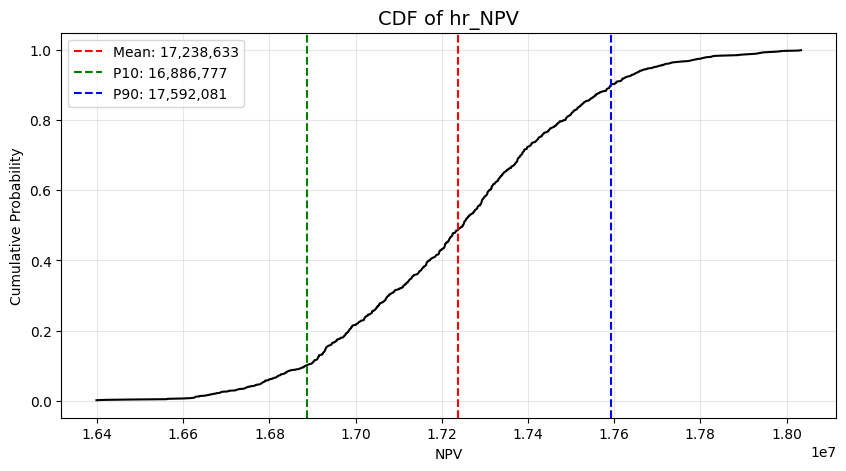

In [81]:
# ---------------- Example usage ----------------
# For exponential model - Total Production
summary_ex_prod = summarize_and_plot(mc_results, "hr", "TotalProd")

# For exponential model - NPV
summary_ex_npv = summarize_and_plot(mc_results, "hr", "NPV")

# Repeat with "hp" or "hr" for other models